In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import display, clear_output

import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

from torch.utils.tensorboard import SummaryWriter
from itertools import product

#confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%load_ext autoreload
%autoreload 2
from utils.plotcm import plot_confusion_matrix

#Runbuilder
from collections import OrderedDict
from collections import namedtuple
from itertools import product

import pandas as pd
import time
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='/home/cstx2/datarepo/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [4]:
print(len(train_set))
print(len(train_set.targets)) # labels

60000
60000


In [12]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.fc1(t.reshape(-1, 12 * 4 * 4)))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        #t = F.softmax(t, dim=1)
        
        return t

In [5]:
torch.set_grad_enabled(False)

In [6]:
network = Network()

In [7]:
sample = next(iter(train_set))

In [8]:
image, label = sample
image.shape

torch.Size([1, 28, 28])

In [9]:
image.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [10]:
pred = network(image.unsqueeze(0)) # image size to match (batch_size x in_channels x H x W)

In [11]:
pred.shape

torch.Size([1, 10])

In [12]:
pred

tensor([[-0.0493,  0.0005, -0.0029,  0.1402,  0.0553, -0.1380, -0.0999,  0.0417, -0.0341,  0.0634]])

In [13]:
label

9

In [14]:
pred.argmax(dim=1)

tensor([3])

In [15]:
F.softmax(pred, dim=1)

tensor([[0.0951, 0.1000, 0.0996, 0.1150, 0.1056, 0.0870, 0.0904, 0.1042, 0.0966, 0.1065]])

In [16]:
F.softmax(pred, dim=1).sum()

tensor(1.0000)

In [17]:
network = Network()

In [18]:
data_loader = torch.utils.data.DataLoader(
    train_set, batch_size=10
)

In [19]:
batch = next(iter(data_loader))
images, labels = batch

In [20]:
print(images.shape)
print(labels.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10])


In [21]:
preds = network(images)
print(preds.shape)

torch.Size([10, 10])


In [22]:
print(preds.argmax(dim=1))
print(labels)

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7])
tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])


In [23]:
print(preds.argmax(dim=1).eq(labels))
print(preds.argmax(dim=1).eq(labels).sum())

tensor([False, False, False, False, False, False,  True, False, False, False])
tensor(1)


In [4]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [25]:
get_num_correct(preds, labels)

1

In [26]:
output = network(image.unsqueeze(0))
print(output)

tensor([[ 0.0216, -0.0056, -0.0986, -0.0218, -0.0838, -0.0310,  0.0886,  0.1335, -0.1084, -0.1069]])


In [27]:
torch.set_grad_enabled(True)

In [28]:
network = Network()

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=100, shuffle=True
)

batch = next(iter(train_loader))
images, labels = batch

In [30]:
preds = network(images)
loss = F.cross_entropy(preds, labels)
loss.item()

2.289112091064453

Calculating the Gradients

In [31]:
print(network.conv1.weight.grad)

None


In [32]:
loss.backward()

In [33]:
print(network.conv1.weight.shape)
print(network.conv1.weight.grad.shape)

torch.Size([6, 1, 5, 5])
torch.Size([6, 1, 5, 5])


Updating Weights

In [34]:
optimizer = optim.Adam(network.parameters(), lr=0.01)
loss.item()
print(get_num_correct(preds, labels))

11


In [35]:
optimizer.step() # update weights
preds = network(images)
loss = F.cross_entropy(preds, labels)
print(loss.item())
print(get_num_correct(preds, labels))

2.2576115131378174
13


In [36]:
network = Network()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

optimizer = optim.Adam(network.parameters(), lr=0.01)

batch = next(iter(train_loader)) # Get Batch
images, labels = batch

preds = network(images) # Pass Batch
loss = F.cross_entropy(preds, labels) # Calculate Loss

loss.backward() # Calculate Gradients
optimizer.step() # Update Weights

print(loss.item())
preds = network(images)
loss = F.cross_entropy(preds, labels)
print(loss.item())


2.315744638442993
2.3005053997039795


Starting out with TensorBoard

In [37]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(1):
    total_loss = 0
    total_correct = 0

    for batch in train_loader:
        images, labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss)

epoch: 0 total_correct: 47517 loss: 333.4685248732567


In [38]:
total_correct / len(train_set)

0.79195

Getting Predictions for the entire training set

In [39]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            , dim=0
        )
        
    return all_preds

In [40]:
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
train_preds = get_all_preds(network, prediction_loader)

In [41]:
train_preds.shape

torch.Size([60000, 10])

In [42]:
print(train_preds.requires_grad)

True


In [43]:
train_preds.grad

In [44]:
train_preds.grad_fn

In [45]:
# with torch.no_grad():
#     prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
#     train_preds = get_all_preds(network, prediction_loader)

In [46]:
print(train_preds.requires_grad)

True


In [47]:
train_preds.grad

In [48]:
train_preds.grad_fn

In [49]:
preds_correct = get_num_correct(train_preds, train_set.targets)

print('total_correct:', preds_correct)
print('accuracy:', preds_correct / len(train_set))

total_correct: 49955
accuracy: 0.8325833333333333


Building confusing matrix

In [50]:
print(train_set.targets)
print(train_preds.argmax(dim=1))

tensor([9, 0, 0,  ..., 3, 0, 5])
tensor([9, 0, 3,  ..., 3, 0, 5])


In [51]:
stacked = torch.stack(
    (
        train_set.targets #true label
        ,train_preds.argmax(dim=1) # predicted label
        )
        ,dim=1
)

In [52]:
print(stacked.shape)
print(stacked)
print(stacked[0].tolist())
cmt = torch.zeros(10,10,dtype=torch.int32)

torch.Size([60000, 2])
tensor([[9, 9],
        [0, 0],
        [0, 3],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])
[9, 9]


In [53]:
for p in stacked:
    true_label, predicted_label = p.tolist()
    cmt[true_label, predicted_label] = cmt[true_label, predicted_label] + 1

In [67]:
cmt

tensor([[5183,   33,   61,  145,   50,    7,  400,    0,  120,    1],
        [  11, 5857,    2,   70,   29,    1,   17,    0,   13,    0],
        [  44,    7, 3092,   22, 1950,    0,  798,    2,   85,    0],
        [ 319,   82,    6, 4886,  561,    0,  116,    0,   23,    7],
        [   7,    7,  103,   67, 5409,    0,  330,    0,   76,    1],
        [   0,    0,    0,    0,    0, 5092,    0,  633,   28,  247],
        [1339,   34,  232,   86, 1081,    1, 3049,    0,  177,    1],
        [   0,    0,    0,    0,    0,   13,    0, 5780,    5,  202],
        [  14,    2,   11,   21,   37,    7,   20,   21, 5861,    6],
        [   0,    0,    0,    0,    0,    4,    0,  246,    4, 5746]], dtype=torch.int32)

Ploting a confustion matrix

In [71]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
print(type(cm))

<class 'numpy.ndarray'>


Confusion matrix, without normalization
[[5183   33   61  145   50    7  400    0  120    1]
 [  11 5857    2   70   29    1   17    0   13    0]
 [  44    7 3092   22 1950    0  798    2   85    0]
 [ 319   82    6 4886  561    0  116    0   23    7]
 [   7    7  103   67 5409    0  330    0   76    1]
 [   0    0    0    0    0 5092    0  633   28  247]
 [1339   34  232   86 1081    1 3049    0  177    1]
 [   0    0    0    0    0   13    0 5780    5  202]
 [  14    2   11   21   37    7   20   21 5861    6]
 [   0    0    0    0    0    4    0  246    4 5746]]


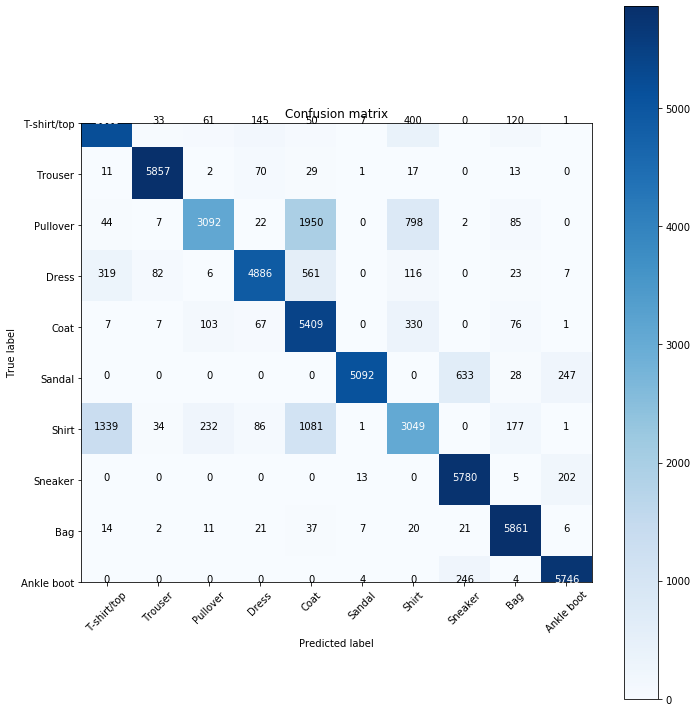

In [72]:
names = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

In [8]:
tb = SummaryWriter()
network = Network()
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(network, images)
tb.close()

In [7]:
batch_size_list = [100, 1000, 10000]
lr_list = [0.01, 0.001, 0.0001, 0.00001]

In [5]:
parameters = dict(
    lr = [0.01, 0.001]
    ,batch_size = [10, 100, 1000]
    ,shuffle = [True, False])

In [10]:
param_values = [v for v in parameters.values()]
for lr, batch_size, shuffle in product(*param_values):
    print(lr, batch_size, shuffle)

0.01 10 True
0.01 10 False
0.01 100 True
0.01 100 False
0.01 1000 True
0.01 1000 False
0.001 10 True
0.001 10 False
0.001 100 True
0.001 100 False
0.001 1000 True
0.001 1000 False


In [6]:
# for batch_size in batch_size_list:
#     for lr in lr_list:
param_values = [v for v in parameters.values()]
for lr, batch_size, shuffle in product(*param_values):
    network = Network()

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    optimizer = optim.Adam(network.parameters(), lr=lr)

    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)

    comment = f' batch_size={batch_size} lr={lr} shuffle={shuffle}'
    tb = SummaryWriter(comment=comment)

    tb.add_image('images', grid)
    tb.add_graph(network, images)

    for epoch in range(3):
        total_loss = 0
        total_correct = 0

        for batch in train_loader:
            images, labels = batch

            preds = network(images)
            loss = F.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_size
            total_correct += get_num_correct(preds, labels)

        tb.add_scalar('Loss', total_loss, epoch)
        tb.add_scalar('Number Correct', total_correct, epoch)
        tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)

    #     tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
    #     tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
    #     tb.add_histogram('conv1.weight.grad', network.conv1.weight.grad, epoch)

        for name, weight in network.named_parameters():
            tb.add_histogram(name, weight, epoch)
            tb.add_histogram(f'{name}.grad', weight.grad, epoch)

        print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss)
tb.close()

epoch: 0 total_correct: 46439 loss: 37137.79315833468
epoch: 1 total_correct: 48930 loss: 30869.782937364653
epoch: 2 total_correct: 49239 loss: 30385.74317484279
epoch: 0 total_correct: 45437 loss: 38370.33829132095
epoch: 1 total_correct: 48229 loss: 32456.187443798408
epoch: 2 total_correct: 48516 loss: 31676.999694765545
epoch: 0 total_correct: 46786 loss: 34267.22459793091
epoch: 1 total_correct: 51486 loss: 22973.275902867317
epoch: 2 total_correct: 52118 loss: 21150.749896466732
epoch: 0 total_correct: 47909 loss: 32323.088379204273
epoch: 1 total_correct: 51778 loss: 22301.018196344376
epoch: 2 total_correct: 52338 loss: 20593.705022335052
epoch: 0 total_correct: 37681 loss: 58155.1833152771
epoch: 1 total_correct: 47306 loss: 31584.15114879608
epoch: 2 total_correct: 50154 loss: 26130.83752989769
epoch: 0 total_correct: 37485 loss: 58229.429721832275
epoch: 1 total_correct: 48562 loss: 30156.63117170334
epoch: 2 total_correct: 50985 loss: 24386.69952750206
epoch: 0 total_corre

In [10]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run = namedtuple('Run', params.keys())
        
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
        return runs

In [16]:
params = OrderedDict(
    lr = [0.01, 0.001]
    ,batch_size = [1000, 10000]
    ,shuffle = [True, False]
)

In [17]:
runs = RunBuilder.get_runs(params)
for run in runs:
    print(run, run.lr, run.batch_size)

Run(lr=0.01, batch_size=1000, shuffle=True) 0.01 1000
Run(lr=0.01, batch_size=1000, shuffle=False) 0.01 1000
Run(lr=0.01, batch_size=10000, shuffle=True) 0.01 10000
Run(lr=0.01, batch_size=10000, shuffle=False) 0.01 10000
Run(lr=0.001, batch_size=1000, shuffle=True) 0.001 1000
Run(lr=0.001, batch_size=1000, shuffle=False) 0.001 1000
Run(lr=0.001, batch_size=10000, shuffle=True) 0.001 10000
Run(lr=0.001, batch_size=10000, shuffle=False) 0.001 10000


In [18]:
Run = namedtuple('Run', params.keys())

runs = []
for v in product(*params.values()):
    runs.append(Run(*v))
runs

[Run(lr=0.01, batch_size=1000, shuffle=True),
 Run(lr=0.01, batch_size=1000, shuffle=False),
 Run(lr=0.01, batch_size=10000, shuffle=True),
 Run(lr=0.01, batch_size=10000, shuffle=False),
 Run(lr=0.001, batch_size=1000, shuffle=True),
 Run(lr=0.001, batch_size=1000, shuffle=False),
 Run(lr=0.001, batch_size=10000, shuffle=True),
 Run(lr=0.001, batch_size=10000, shuffle=False)]

In [21]:
for run in RunBuilder.get_runs(params):
    network = Network()

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=run.batch_size, shuffle=run.shuffle)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)

    comment = f'-{run}'
#     print(comment)
#     print(run.batch_size, run.shuffle, run.lr)
    tb = SummaryWriter(comment=comment)

    tb.add_image('images', grid)
    tb.add_graph(network, images)

    for epoch in range(2):
        total_loss = 0
        total_correct = 0

        for batch in train_loader:
            images, labels = batch

            preds = network(images)
            loss = F.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_size
            total_correct += get_num_correct(preds, labels)

        tb.add_scalar('Loss', total_loss, epoch)
        tb.add_scalar('Number Correct', total_correct, epoch)
        tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)

        for name, weight in network.named_parameters():
            tb.add_histogram(name, weight, epoch)
            tb.add_histogram(f'{name}.grad', weight.grad, epoch)

        print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss)
tb.close()

epoch: 0 total_correct: 36138 loss: 62203.98932695389
epoch: 1 total_correct: 46137 loss: 35604.95084524155
epoch: 0 total_correct: 36468 loss: 61815.98389148712
epoch: 1 total_correct: 47289 loss: 32812.493950128555
epoch: 0 total_correct: 11367 loss: 12538.208723068237
epoch: 1 total_correct: 26232 loss: 8775.149941444397
epoch: 0 total_correct: 16367 loss: 12596.52328491211
epoch: 1 total_correct: 26105 loss: 8853.223204612732
epoch: 0 total_correct: 27249 loss: 95692.86143779755
epoch: 1 total_correct: 41475 loss: 48863.76595497131
epoch: 0 total_correct: 28263 loss: 94926.1873960495
epoch: 1 total_correct: 41435 loss: 48510.17051935196
epoch: 0 total_correct: 6961 loss: 13749.882459640503
epoch: 1 total_correct: 12916 loss: 13435.518503189087
epoch: 0 total_correct: 6000 loss: 13809.469938278198
epoch: 1 total_correct: 10319 loss: 13708.95767211914


In [39]:
class RunManager():
    def __init__(self):
        
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None
        self.loader = None
        self.tb = None
        
    def begin_run(self, run, network, loader):
        self.run_start_time = time.time()
        
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}')
        
        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image('image', grid)
        self.tb.add_graph(self.network, images)
        
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0
        
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)
        
        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
        
        for name, weight in network.named_parameters():
            self.tb.add_histogram(name, weight, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', weight.grad, self.epoch_count)
            
            results = OrderedDict()
            results["run"] = self.run_count
            results["epoch"] = self.epoch_count
            results["loss"] = loss
            results["accuracy"] = accuracy
            results["epoch duration"] = epoch_duration
            results["run duration"] = run_duration
            
            for k,v in self.run_params._asdict().items(): results[k] = v
            self.run_data.append(results)
            df = pd.DataFrame.from_dict(self.run_data, orient='columns')
            
            # Jupiter housekeeping to update results
            clear_output(wait=True)
            display(df)
            
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * self.loader.batch_size

    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)

    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()

    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data, orient='columns'
        ).to_csv(f'{fileName}.csv')

        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [42]:
params = OrderedDict(
    lr = [0.01]
    ,batch_size = [1000]
    ,num_workers = [0, 1, 2, 4, 8, 16]
    #,shuffle = [True, False]
)

m = RunManager()

for run in RunBuilder.get_runs(params):
    network = Network()
    train_loader = DataLoader(train_set, batch_size=run.batch_size, num_workers=run.num_workers)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)
    
    m.begin_run(run, network, loader)
    for epoch in range(1):
        m.begin_epoch()

        for batch in train_loader:
            images = batch[0]
            labels = batch[1]

            preds = network(images) # pass Batch
            loss = F.cross_entropy(preds, labels) # calculate loss

            optimizer.zero_grad() # Zero gradients
            loss.backward() # Calculate gradients
            optimizer.step() # Update Weights

            m.track_loss(loss)

            m.track_num_correct(preds, labels)

        m.end_epoch()
    m.end_run()
#m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers
0,1,1,1.996312,0.621950,41.464276,45.221494,0.01,1000,0
1,1,1,1.996312,0.621950,41.464276,45.221494,0.01,1000,0
2,1,1,1.996312,0.621950,41.464276,45.221494,0.01,1000,0
3,1,1,1.996312,0.621950,41.464276,45.221494,0.01,1000,0
4,1,1,1.996312,0.621950,41.464276,45.221494,0.01,1000,0
5,1,1,1.996312,0.621950,41.464276,45.221494,0.01,1000,0
6,1,1,1.996312,0.621950,41.464276,45.221494,0.01,1000,0
7,1,1,1.996312,0.621950,41.464276,45.221494,0.01,1000,0
8,1,1,1.996312,0.621950,41.464276,45.221494,0.01,1000,0
9,1,1,1.996312,0.621950,41.464276,45.221494,0.01,1000,0
